# Dimensionality reduction with principal component analysis

In previous steps we managed to prepare the original data for model creation. The ready dataset includes 112 columns.

The scope of this notebook is to use principal component analysis (PCA) in order to reduce the dimensionality of the original data. PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as weighted, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data.

In [1]:
import pandas as pd
import numpy as np
import os
import sagemaker
from sagemaker import get_execution_role, PCA
import boto3
import mxnet as mx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

## Load data

In [2]:
input_file_path = 'data/data_ready.csv'
data_ready = pd.read_csv(input_file_path)

The DataFrame is converted to the needed type. Moreover, we isolate the dependent variables by excluding the dependent/target variable `NetSalary`.

In [3]:
data_ready = data_ready.astype(np.float32)

data_ready_features = data_ready.drop(labels=['NetSalary'], axis=1)
data_ready_features.head()

,SuperivisionRole,WorkOutsideMainJob,ai / ml,backend,bi,data,desktop,devops,drupal,embedded,...,CityLive_Piraeus,CityLive_Rethimno,CityLive_Salamis,CityLive_Serres,CityLive_Stockholm,CityLive_Thessaloniki,CityLive_Tripoli,CityLive_Vienna,CityLive_Volos,CityLive_Xanthi
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Principal component analysis model

After retrieving any necessary configuration values, the principal component analysis model is created. The model should consist of 111 components. In the next steps a subset of components will be selected.

In [4]:
# get session, IAM role, default bucket
session = sagemaker.Session()
role = get_execution_role()
bucket_name = session.default_bucket()

# define location to store model artifacts
prefix = 'udacity-nd009t-capstone-project'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

In [5]:
# define a PCA model
# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=112 - 1

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [6]:
# convert df to np array
# train_data_np = counties_scaled.values.astype('float32')
train_data_np = data_ready_features.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

The model is trained.

In [7]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-29 15:58:58 Starting - Starting the training job...
2020-10-29 15:59:00 Starting - Launching requested ML instances.........
2020-10-29 16:00:36 Starting - Preparing the instances for training...
2020-10-29 16:01:25 Downloading - Downloading input data...
2020-10-29 16:01:47 Training - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/29/2020 16:03:15 INFO 140470504032064] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/29/2020 16:03:15 INFO 140470504032064] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'112', u'mini_batch_size': u'500', u'n


2020-10-29 16:03:25 Uploading - Uploading generated training model
2020-10-29 16:03:25 Completed - Training job completed
Training seconds: 120
Billable seconds: 120
CPU times: user 570 ms, sys: 33.2 ms, total: 603 ms
Wall time: 4min 42s


We load the output model in order to retrieve the model parameters.

In [8]:
# Get the name of the training job, it's suggested that you copy-paste
# from the notebook or from a specific job in the AWS console

training_job_name='pca-2020-10-29-15-58-58-608'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
# print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [9]:
# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
# print(pca_model_params)

In [10]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [11]:
# looking at top 18 components
n_principal_components = 18

start_idx = N_COMPONENTS - n_principal_components

# print a selection of s
print(s.iloc[start_idx:, :])

             0
93    7.391248
94    7.511139
95    7.820765
96    8.192153
97    8.538879
98    8.758378
99    9.155324
100   9.286876
101   9.681390
102   9.998695
103  10.582881
104  11.343452
105  11.828951
106  12.776322
107  13.411459
108  15.376316
109  15.741590
110  19.784815


### Explained data variance

The PCA model creates 111 principal components, but when creating new dimensionality-reduced training data, only a few top n components should be selected. To decide how many top components to include, it's helpful to look at how much data variance the components capture. A helper function is defined below that calculates the explained variance.

In [12]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

For the original, high-dimensional data, 112 features captured 100% of our data variance. The goal is to reduce the dimensions in order to capture 80%-90%. It was decided to keep the top 18 components.

In [13]:
n_top_components = 18 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8088978


### Component makeup analysis

A helper function is defined in order to examine the makeup of each PCA component based on the weightings of the original features that are included in the component.

In [14]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

The following code shows the feature-level makeup of the first component.

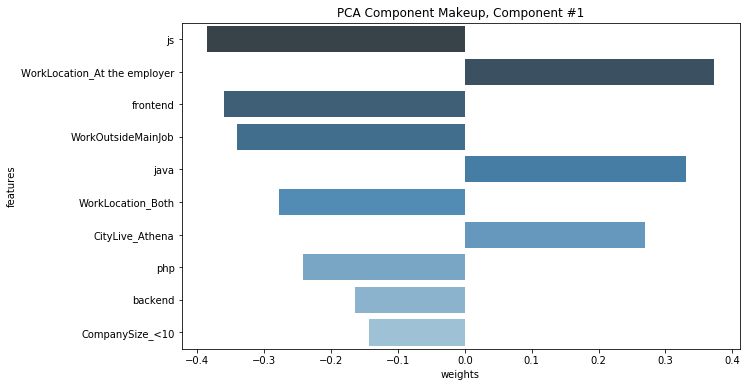

In [15]:
%matplotlib inline 
# display makeup of first component
num=1
display_component(v, data_ready_features, component_num=num, n_weights=10)

The following code shows the feature-level makeup of the second component.

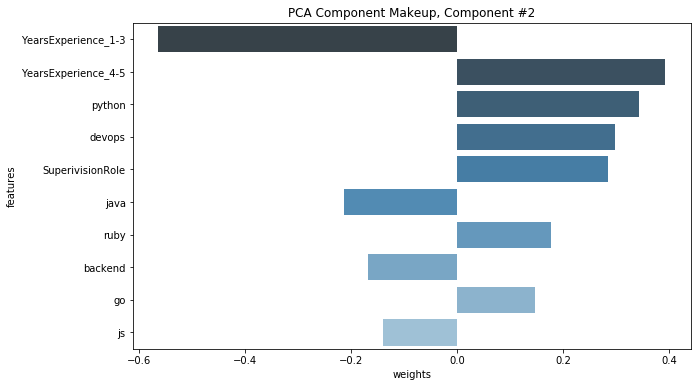

In [16]:
%matplotlib inline 
# display makeup of first component
num=2
display_component(v, data_ready_features, component_num=num, n_weights=10)

## Transform data

The model is deployed and used in order to transform the original data.

In [17]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------!CPU times: user 339 ms, sys: 13.3 ms, total: 352 ms
Wall time: 9min 33s


In [18]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(data_ready_features.values)

Then the largest n components are selected to reduce the dimensionality of the dataset.

In [19]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    data_ready_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        data_ready_transformed=data_ready_transformed.append([list(components)])

    # index by county, just like counties_scaled
    data_ready_transformed.index=counties_scaled.index

    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    data_ready_transformed = data_ready_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return data_ready_transformed.iloc[:, ::-1]

In [20]:
# Specify top n
top_n = 18

# call your function and create a new dataframe
data_ready_transformed = create_transformed_df(train_pca, data_ready_features, n_top_components=top_n)

# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7','c_8', 'c_9', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14','c_15', 'c_16', 'c_17', 'c_18']
data_ready_transformed.columns=PCA_list 

# print result
data_ready_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18
0,-1.491342,0.499634,-0.246501,-0.013990,0.122125,0.641558,0.995069,-0.566953,-0.535222,-0.221655,0.156440,0.350517,-0.177770,-0.122503,0.151946,0.744834,0.281528,0.573844
1,-0.655306,-0.969973,-0.163931,-0.454757,0.761710,0.588066,0.454240,0.052555,0.352372,0.546993,0.029524,-0.017812,-0.102289,-0.062792,-0.216299,0.600695,0.317243,0.123078
2,-0.758965,-0.449133,0.749488,0.417095,-0.005073,0.753143,0.681534,-0.473462,-0.168147,0.097466,-0.279967,-0.422298,-0.091360,0.551935,-0.614136,-0.085850,0.373777,-0.116853
3,-0.421834,0.116480,-0.543815,0.766281,-0.964952,1.075574,0.477425,0.632098,0.344622,0.048370,0.119166,0.188046,-0.130923,-0.102078,-0.303772,0.435454,0.711709,-0.033842
4,-0.799304,-0.547005,0.467526,0.169639,0.199666,0.866347,0.437763,-1.026231,0.135216,-0.215621,-0.164567,-0.365027,0.053935,0.291851,-0.363867,-0.240961,0.025495,0.195494


The `NetSalary` column is added back to the transformed DataFrame.

In [21]:
data_ready_transformed['NetSalary'] = data_ready['NetSalary']
data_ready_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579 entries, 0 to 578
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   c_1        579 non-null    float64
 1   c_2        579 non-null    float64
 2   c_3        579 non-null    float64
 3   c_4        579 non-null    float64
 4   c_5        579 non-null    float64
 5   c_6        579 non-null    float64
 6   c_7        579 non-null    float64
 7   c_8        579 non-null    float64
 8   c_9        579 non-null    float64
 9   c_10       579 non-null    float64
 10  c_11       579 non-null    float64
 11  c_12       579 non-null    float64
 12  c_13       579 non-null    float64
 13  c_14       579 non-null    float64
 14  c_15       579 non-null    float64
 15  c_16       579 non-null    float64
 16  c_17       579 non-null    float64
 17  c_18       579 non-null    float64
 18  NetSalary  579 non-null    float32
dtypes: float32(1), float64(18)
memory usage: 83.8 KB


## Save data

In [22]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

output_file = 'data_ready_pca.csv'
data_ready_transformed.to_csv(os.path.join(data_dir, output_file), index=False)

## Cleanup

In [23]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)